# CLIP With early stopping

accuracy: 0.7321  
val_accuracy: 0.6949  
Precision: 0.4666  
Recall: 0.4671  
F1-Score: 0.4604  
Weighted F1-Score: 0.6787

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Concatenate image and text features
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        combined_features = Concatenate()([image_features, text_features])
        
        # Classification head
        x = Dense(512, activation='relu')(combined_features)
        x = Dropout(0.3)(x)
        x = LayerNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, epochs=30):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks
    )
    
    return model, history

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    roc_auc = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr')
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping

accuracy: 0.7624  
val_accuracy: 0.7177     
Precision: 0.6341  
Recall: 0.4891  
F1-Score: 0.4912  
Weighted F1-Score: 0.6910    

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Concatenate image and text features
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        combined_features = Concatenate()([image_features, text_features])
        
        # Classification head
        x = Dense(512, activation='relu')(combined_features)
        x = Dropout(0.3)(x)
        x = LayerNormalization()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, epochs=20):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping  
## Handle class imbalance + Modify model architecture

accuracy: 0.6405  
val_accuracy: 0.5863     
Precision: 0.5504  
Recall: 0.6473  
F1-Score: 0.5263  
Weighted F1-Score: 0.6227    

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=20):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping  
## Handle class imbalance + Modify model architecture 
## Increased Dropout + Increased learning rate to 2e-4 + epoch 50

accuracy: 0.9311   
val_accuracy: 0.6960         
Precision: 0.5589  
Recall: 0.5826  
F1-Score: 0.5679  
Weighted F1-Score: 0.7027     

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.4)(x) # increased dropout
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-4) #increased learning rate
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=50):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping  
## Handle class imbalance + Modify model architecture 
## Increased Dropout + Decreased learning rate to 2e-5 + epoch 50

accuracy: 0.7218  
val_accuracy: 0.6400         
Precision: 0.5467  
Recall: 0.6223  
F1-Score: 0.5521  
Weighted F1-Score: 0.6651     

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.4)(x) # increased dropout
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5) #increased learning rate
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=50):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping  
## Handle class imbalance + Modify model architecture 
## Unfreeze CLIP layer + epoch 50 (high overfitting)

accuracy: 0.7218  
val_accuracy: 0.6400         
Precision: 0.5467  
Recall: 0.6223  
F1-Score: 0.5521  
Weighted F1-Score: 0.6651     

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Fine-tune the entire CLIP model
        self.clip.trainable = True
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=50):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP without early stopping with K-fold Cross validation
## Handle class imbalance + Modify model architecture 
## Increased Dropout + Decreased learning rate to 2e-5 + epoch 50

accuracy: 0.7218  
val_accuracy: 0.6400         
Precision: 0.5467  
Recall: 0.6223  
F1-Score: 0.5521  
Weighted F1-Score: 0.6651     

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.4)(x) # increased dropout
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5) #increased learning rate
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=20):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

from sklearn.model_selection import StratifiedKFold

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Get image paths and texts
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    image_paths = get_image_paths(memes_folder, combined_df['image_name'].tolist())
    texts = combined_df['Captions'].tolist()
    labels = combined_df['Label_Sentiment'].values

    # Initialize k-fold cross-validation
    k = 4  # Number of folds
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
        print(f"\nTraining Fold {fold + 1}/{k}")
        
        # Split data into training and validation sets
        train_image_paths = [image_paths[i] for i in train_idx]
        train_texts = [texts[i] for i in train_idx]
        train_labels = labels[train_idx]
        
        val_image_paths = [image_paths[i] for i in val_idx]
        val_texts = [texts[i] for i in val_idx]
        val_labels = labels[val_idx]

        # Handle class imbalance
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )
        class_weights = dict(enumerate(class_weights))

        # Train model
        model, history = train_model(
            train_image_paths, train_texts, train_labels,
            val_image_paths, val_texts, val_labels, class_weights
        )

        # Evaluate model on the validation set
        val_inputs = process_data_batch(val_image_paths, val_texts, model_handler=CLIPSentimentModel())
        evaluate_model(model, val_inputs, val_labels, label_map)

        # Store fold results
        fold_results.append({
            'val_accuracy': history.history['val_accuracy'][-1],
            'val_loss': history.history['val_loss'][-1],
            'val_f1': f1_score(val_labels, np.argmax(model.predict(val_inputs), axis=1), average='weighted')
        })

    # Aggregate results across folds
    avg_val_accuracy = np.mean([result['val_accuracy'] for result in fold_results])
    avg_val_loss = np.mean([result['val_loss'] for result in fold_results])
    avg_val_f1 = np.mean([result['val_f1'] for result in fold_results])
    print(f"\nAverage Validation Accuracy: {avg_val_accuracy:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}")
    print(f"Average Validation Weighted F1-Score: {avg_val_f1:.4f}")

    # Train final model on the entire dataset (optional)
    print("\nTraining final model on the entire dataset...")
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    class_weights = dict(enumerate(class_weights))

    final_model, _ = train_model(
        image_paths, texts, labels,
        image_paths, texts, labels, class_weights  # Use the same data for validation (optional)
    )

    # Save the final model
    final_model.save('final_model.h5')
    print("Final model saved to final_model.h5")

if __name__ == "__main__":
    main()

# CLIP best wf score model (Result very poor)

Modified loss function. Added Focal Loss Instead of Cross-Entropy.  



In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        x = Dense(768, activation='gelu')(combined_features)
        x = Dropout(0.4)(x)
        x = BatchNormalization()(x)
        x = Dense(384, activation='gelu')(x)
        x = Dropout(0.4)(x) # increased dropout
        outputs = Dense(self.num_classes, activation='softmax')(x)
        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-4) #increased learning rate

        # Use focal loss to focus on harder to find examples
        model.compile(
            optimizer=Adam(learning_rate=2e-5),
            loss=tfa.losses.SigmoidFocalCrossEntropy(),
            metrics=['accuracy']
        )

        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=30):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP best wf score model
## Increased LR 2e-4

Added more hidden layers to capture complex relationships.

accuracy: 0.8676   
val_accuracy: 0.6000  
Precision: 0.5227  
Recall: 0.5607  
F1-Score: 0.5027  
Weighted F1-Score: 0.6371  

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        # Added more hidden layers. larger layers help capture complex features
        x = Dense(768, activation='gelu')(combined_features)  # Increased units
        x = Dropout(0.4)(x)  # Higher dropout to prevent overfitting
        x = LayerNormalization()(x)
        x = Dense(512, activation='gelu')(x)
        x = Dropout(0.3)(x)
        x = Dense(256, activation='gelu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-4) #increased learning rate

        # Use focal loss to focus on harder to find examples
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=30):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP best wf score model
## Decreased LR 2e-5

Added more hidden layers to capture complex relationships.

accuracy: 0.5756   
val_accuracy: 0.5669  
Precision: 0.5173  
Recall: 0.5818  
F1-Score: 0.5026  
Weighted F1-Score: 0.6047  

Combined DataFrame Columns: Index(['image_name', 'Captions', 'Label_Sentiment'], dtype='object')
Number of missing values in 'Label_Sentiment': 12
Unique values in 'Label_Sentiment': ['positive' 'negative' 'neutral' nan]


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Processing training data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/nurani-memes (149).jpg: image file is truncated (3 bytes not processed)
Processing validation data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Er

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png'
28/28 [==============================] - 11s 192ms/step
Precision: 0.5173
Recall: 0.5818
F1-Score: 0.5026
Weighted F1-Score: 0.6047


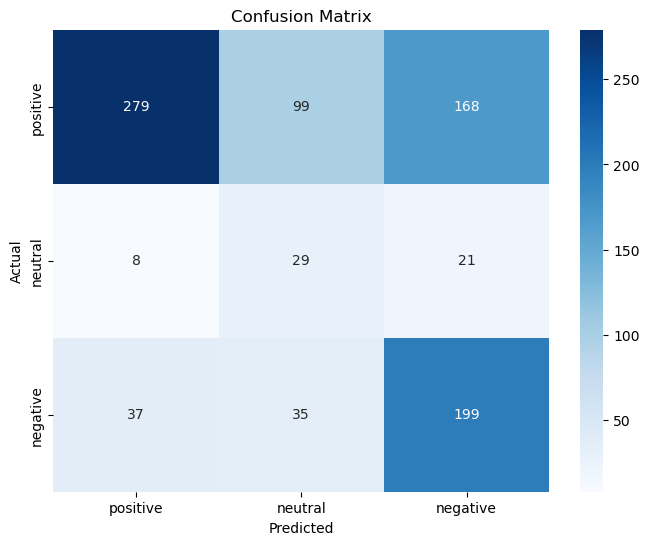

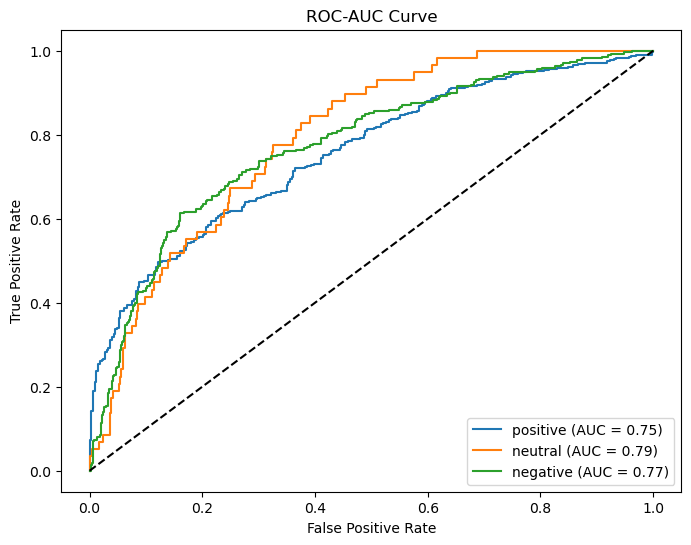

Macro-average ROC-AUC Score: 0.7739


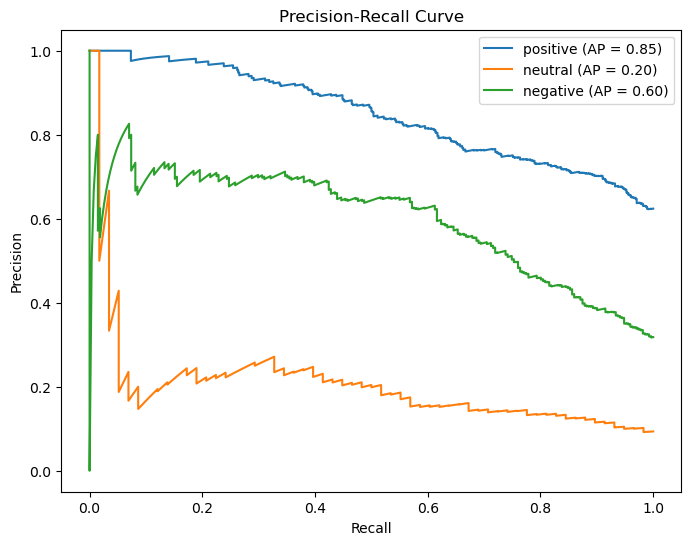

28/28 [==============================] - 5s 196ms/step
Predictions saved to submission.csv


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        # Added more hidden layers. larger layers help capture complex features
        x = Dense(768, activation='gelu')(combined_features)  # Increased units
        x = Dropout(0.4)(x)  # Higher dropout to prevent overfitting
        x = LayerNormalization()(x)
        x = Dense(512, activation='gelu')(x)
        x = Dropout(0.3)(x)
        x = Dense(256, activation='gelu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5) #increased learning rate

        # Use focal loss to focus on harder to find examples
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=32):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=100):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP best wf score model
## Decreased LR 2e-5 + batch_size=16

Added more hidden layers to capture complex relationships.

accuracy: 0.7083  
val_accuracy: 0.6320   
Precision: 0.5517  
Recall: 0.6316  
F1-Score: 0.5496  
Weighted F1-Score: 0.6625    

Combined DataFrame Columns: Index(['image_name', 'Captions', 'Label_Sentiment'], dtype='object')
Number of missing values in 'Label_Sentiment': 12
Unique values in 'Label_Sentiment': ['positive' 'negative' 'neutral' nan]


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Processing training data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/nurani-memes (149).jpg: image file is truncated (3 bytes not processed)
Processing validation data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Er

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png'
28/28 [==============================] - 11s 193ms/step
Precision: 0.5517
Recall: 0.6316
F1-Score: 0.5496
Weighted F1-Score: 0.6625


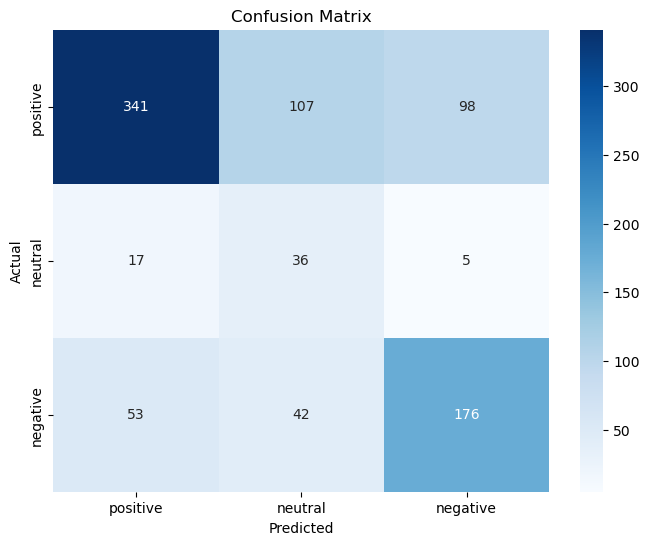

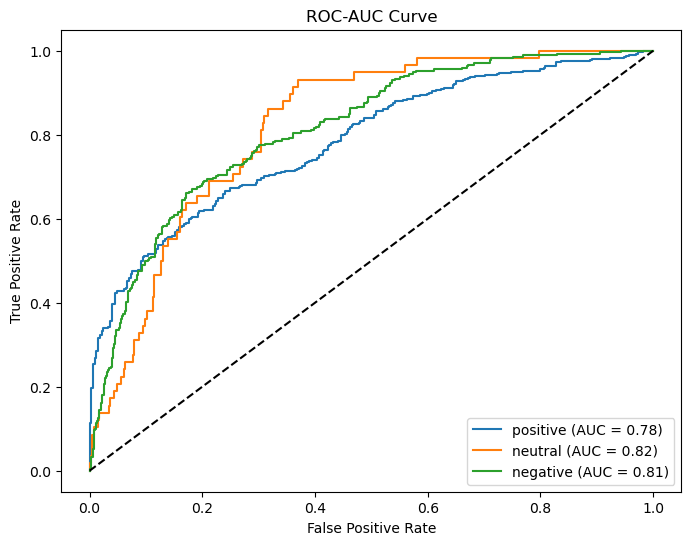

Macro-average ROC-AUC Score: 0.8054


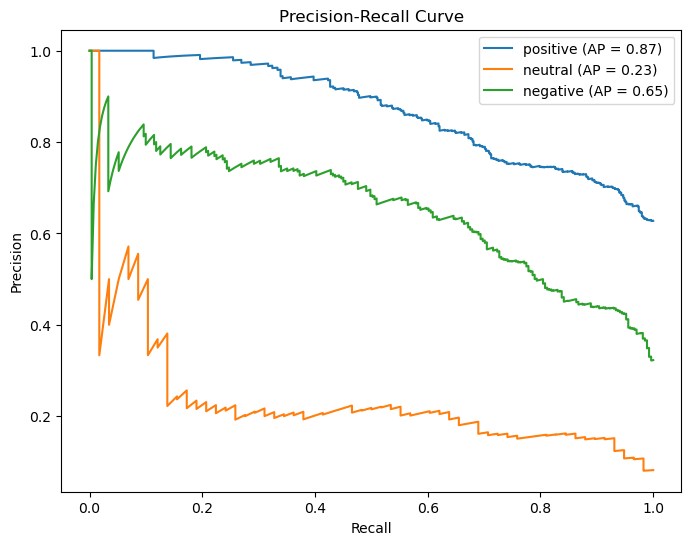

28/28 [==============================] - 5s 194ms/step
Predictions saved to submission.csv


In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        # Added more hidden layers. larger layers help capture complex features
        x = Dense(768, activation='gelu')(combined_features)  # Increased units
        x = Dropout(0.4)(x)  # Higher dropout to prevent overfitting
        x = LayerNormalization()(x)
        x = Dense(512, activation='gelu')(x)
        x = Dropout(0.3)(x)
        x = Dense(256, activation='gelu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5) #increased learning rate

        # Use focal loss to focus on harder to find examples
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=16):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=30):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=16,
        class_weight=class_weights,
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()

# CLIP best wf score model
## Decreased LR 2e-5 + batch_size=8

Added more hidden layers to capture complex relationships.

accuracy: 0.7361  
val_accuracy: 0.6103   
Precision: 0.5422  
Recall: 0.6218  
F1-Score: 0.5325  
Weighted F1-Score: 0.6450     

Combined DataFrame Columns: Index(['image_name', 'Captions', 'Label_Sentiment'], dtype='object')
Number of missing values in 'Label_Sentiment': 12
Unique values in 'Label_Sentiment': ['positive' 'negative' 'neutral' nan]


All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Processing training data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/nurani-memes (149).jpg: image file is truncated (3 bytes not processed)
Processing validation data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Er

All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-base-patch32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).jpg'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (128) (1).png'
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png: [Errno 2] No such file or directory: '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/KAM (103) (1).png'
28/28 [==============================] - 10s 192ms/step
Precision: 0.5422
Recall: 0.6218
F1-Score: 0.5325
Weighted F1-Score: 0.6450


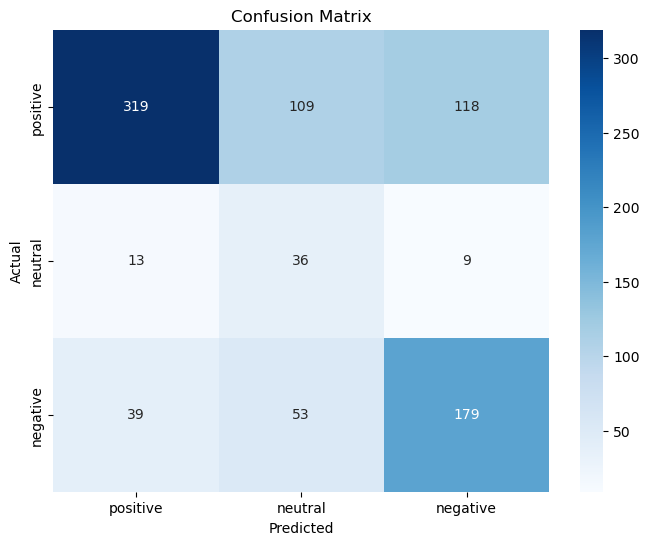

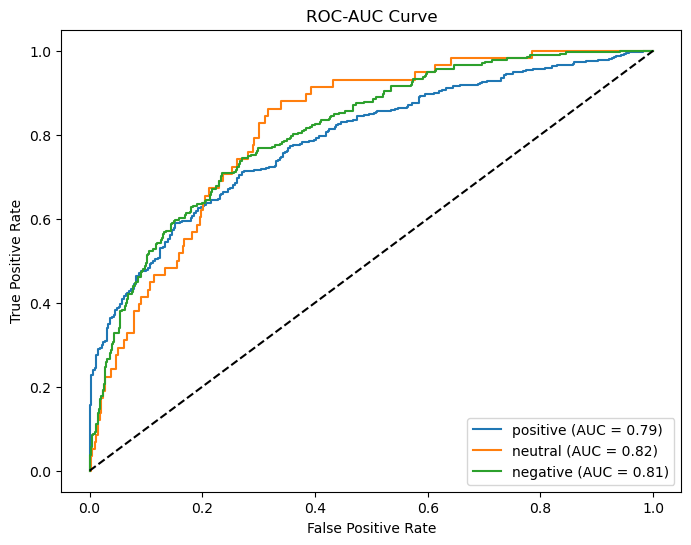

Macro-average ROC-AUC Score: 0.8041


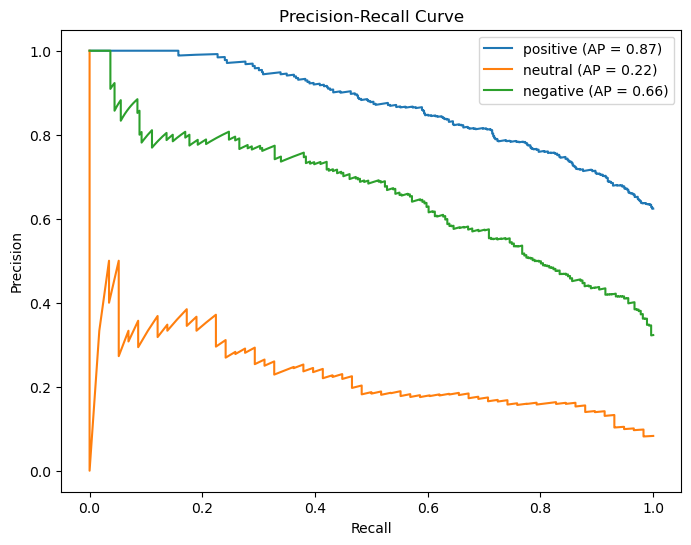

28/28 [==============================] - 5s 194ms/step
Predictions saved to submission.csv


In [4]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import CLIPProcessor, TFCLIPModel
from tensorflow.keras.layers import Dense, Input, Dropout, LayerNormalization, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import gelu
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa

def load_data(train_path, test_path):
    """Load training and test data"""
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    return train_df, test_df

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class CLIPSentimentModel:
    def __init__(self, num_classes=3):
        self.num_classes = num_classes
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip = TFCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze CLIP layers
        self.clip.trainable = False
    
    def process_batch(self, images, texts):
        """Process a batch of images and texts through CLIP"""
        inputs = self.processor(
            images=images,
            text=texts,
            return_tensors="tf",
            padding='max_length',  # Ensure consistent padding
            truncation=True,       # Truncate sequences longer than max_length
            max_length=77          # Default sequence length for CLIP
        )
        return inputs
    
    def build_model(self):
        # Define inputs
        input_ids = Input(shape=(77,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(77,), dtype=tf.int32, name='attention_mask')
        pixel_values = Input(shape=(3, 224, 224), dtype=tf.float32, name='pixel_values')
        
        # Get CLIP embeddings
        clip_outputs = self.clip(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values
        )
        
        # Improved feature fusion
        image_features = clip_outputs.image_embeds
        text_features = clip_outputs.text_embeds
        
        # Normalize features
        image_features = tf.math.l2_normalize(image_features, axis=1)
        text_features = tf.math.l2_normalize(text_features, axis=1)
        
        # Multi-modal interaction
        combined_features = Concatenate()([
            image_features, 
            text_features, 
            image_features * text_features  # Cross-modality interaction
        ])
        
        # Enhanced classifier head
        # Added more hidden layers. larger layers help capture complex features
        x = Dense(768, activation='gelu')(combined_features)  # Increased units
        x = Dropout(0.4)(x)  # Higher dropout to prevent overfitting
        x = LayerNormalization()(x)
        x = Dense(512, activation='gelu')(x)
        x = Dropout(0.3)(x)
        x = Dense(256, activation='gelu')(x)
        x = Dropout(0.2)(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        
        # Build and compile model
        model = Model(
            inputs=[input_ids, attention_mask, pixel_values],
            outputs=outputs
        )
        
        optimizer = Adam(learning_rate=2e-5) #increased learning rate

        # Use focal loss to focus on harder to find examples
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        
        return model

def process_data_batch(image_paths, texts, model_handler, batch_size=8):
    """Process data in batches to avoid memory issues"""
    all_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        # Load images for current batch
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                # Create a blank image as fallback
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        # Process batch with consistent padding
        inputs = model_handler.process_batch(batch_images, batch_texts)
        
        # Debug: Print shapes of input_ids and attention_mask
        # print(f"Batch {i//batch_size + 1}:")
        # print("input_ids shape:", inputs['input_ids'].shape)
        # print("attention_mask shape:", inputs['attention_mask'].shape)
        # print("pixel_values shape:", inputs['pixel_values'].shape)
        
        all_inputs.append(inputs)
    
    # Combine all batches
    combined_inputs = {
        'input_ids': tf.concat([x['input_ids'] for x in all_inputs], axis=0),
        'attention_mask': tf.concat([x['attention_mask'] for x in all_inputs], axis=0),
        'pixel_values': tf.concat([x['pixel_values'] for x in all_inputs], axis=0)
    }
    
    return combined_inputs

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, class_weights, epochs=30):
    # Create model instance
    model_handler = CLIPSentimentModel()
    model = model_handler.build_model()
    
    print("Processing training data...")
    train_inputs = process_data_batch(train_image_paths, train_texts, model_handler)
    
    print("Processing validation data...")
    val_inputs = process_data_batch(val_image_paths, val_texts, model_handler)
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]
    
    # Train model
    history = model.fit(
        train_inputs,
        train_labels,
        validation_data=(val_inputs, val_labels),
        epochs=epochs,
        batch_size=8,
        class_weight=class_weights,
        # callbacks=callbacks
    )
    
    return model, history

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve

def evaluate_model(model, test_inputs, test_labels, label_map):
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    precision = precision_score(test_labels, predicted_labels, average='macro')
    recall = recall_score(test_labels, predicted_labels, average='macro')
    f1 = f1_score(test_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(test_labels, predicted_labels, average='weighted')
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC-AUC Curve
    y_test_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(label_map))
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")
    
    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])
    
    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def main():
    # Load the combined dataset with the correct encoding
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        # Try alternative encodings if UTF-8 fails
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return
    
    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())
    
    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))
    
    # Train model
    model, history = train_model(
        train_image_paths, train_df['Captions'].tolist(), train_labels,
        test_image_paths, test_df['Captions'].tolist(), test_labels, class_weights
    )
    
    # Process test data
    print("Processing test data...")
    model_handler = CLIPSentimentModel()
    test_inputs = process_data_batch(test_image_paths, test_df['Captions'].tolist(), model_handler)
    
    # Evaluate model on the test set
    evaluate_model(model, test_inputs, test_labels, label_map)
    
    # Make predictions
    predictions = model.predict(test_inputs)
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Convert predictions to original labels
    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predicted_labels]
    
    # Check if 'Id' column exists in test_df
    if 'Id' not in test_df.columns:
        # Create a unique identifier if 'Id' column is missing
        test_df['Id'] = range(1, len(test_df) + 1)
        print("Warning: 'Id' column not found in test_df. A unique identifier has been created.")
    
    # Save predictions
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")
    
    return model, history

if __name__ == "__main__":
    main()